Analysis of Taylor Swift Spotify Data - Predicting Song Popularity

In [1]:
import pandas as pd
import numpy as np
import random

# Models
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xg 
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance

# Data Vis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw = pd.read_csv('~/Desktop/RecreationalCoding/taylor_swift_spotify.csv', index_col=0)
raw.head(2)

,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Lavender Haze,Midnights (3am Edition),2022-10-22,1,4g2c7NoTWAOSYDy44l9nub,spotify:track:4g2c7NoTWAOSYDy44l9nub,0.2040,0.735,0.444,0.0012,0.1700,-10.519,0.0684,97.038,0.0984,74,202395
1,Maroon,Midnights (3am Edition),2022-10-22,2,199E1RRrVmVTQqBXih5qRC,spotify:track:199E1RRrVmVTQqBXih5qRC,0.0593,0.658,0.378,0.0000,0.0976,-8.300,0.0379,108.034,0.0382,74,218270


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1265 entries, 0 to 1264
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1265 non-null   object 
 1   album             1265 non-null   object 
 2   release_date      1265 non-null   object 
 3   track_number      1265 non-null   int64  
 4   id                1265 non-null   object 
 5   uri               1265 non-null   object 
 6   acousticness      1265 non-null   float64
 7   danceability      1265 non-null   float64
 8   energy            1265 non-null   float64
 9   instrumentalness  1265 non-null   float64
 10  liveness          1265 non-null   float64
 11  loudness          1265 non-null   float64
 12  speechiness       1265 non-null   float64
 13  tempo             1265 non-null   float64
 14  valence           1265 non-null   float64
 15  popularity        1265 non-null   int64  
 16  duration_ms       1265 non-null   int64  


Data Exploration

<AxesSubplot:xlabel='popularity', ylabel='Count'>

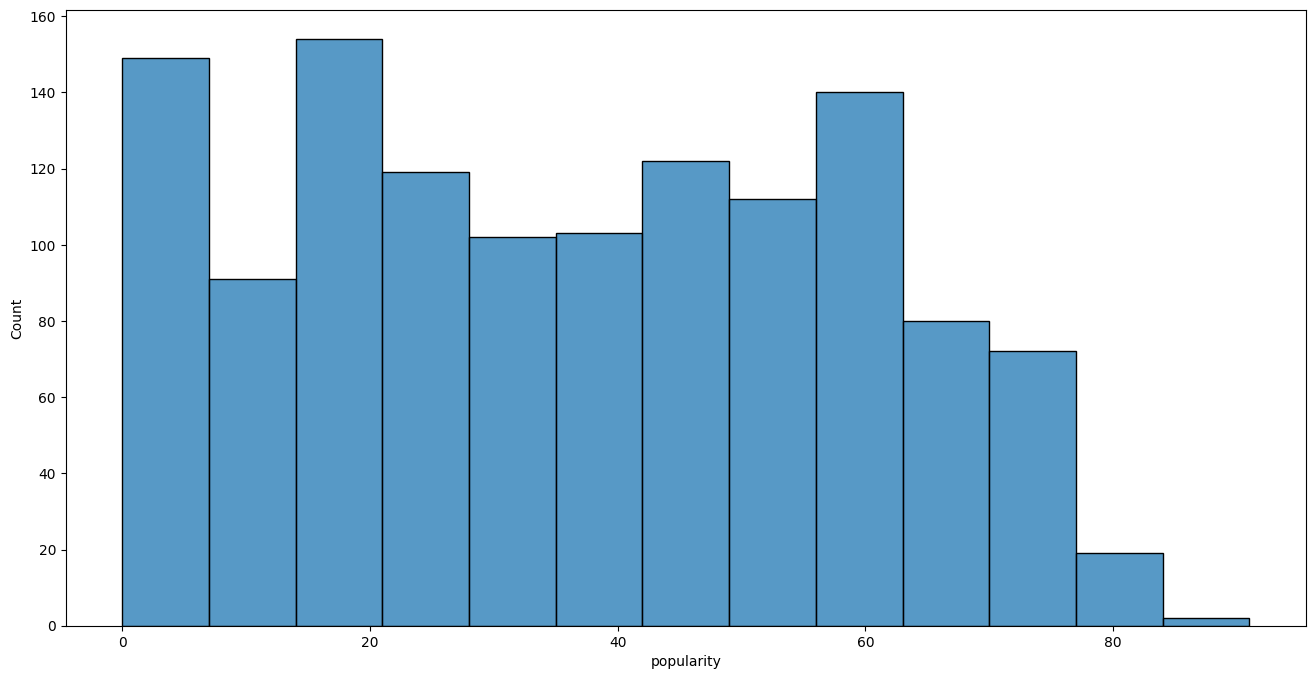

In [4]:
plt.figure(figsize=(16, 8))
sns.histplot(raw["popularity"],bins='auto')

Correlations:

In [5]:
raw['loudness'].corr(raw['energy'])


0.7981539611189447

/var/folders/s6/c2zvps5x2ds8_cjl3p1hyq440000gn/T/ipykernel_78422/678592416.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = raw.corr()


<AxesSubplot:>

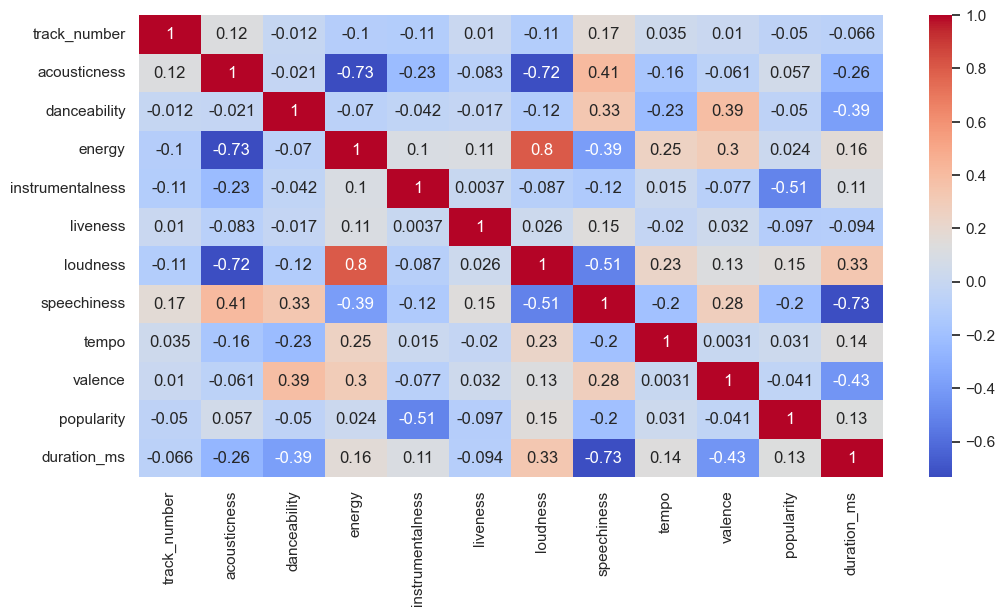

In [6]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
corr = raw.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")

Feature Engineering

In [7]:
raw['album'].value_counts()

folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]    68
Fearless                                                                               63
Red (Taylor's Version)                                                                 60
reputation Stadium Tour Surprise Song Playlist                                         46
evermore                                                                               45
Red (Deluxe Edition)                                                                   44
Midnights (3am Edition)                                                                40
1989                                                                                   39
1989 (Deluxe)                                                                          38
evermore (deluxe version)                                                              34
folklore (deluxe version)                                                              34
1989 (Delu

Removing Karaoke Albums

In [8]:
# remove any rows where the album string contains 'karaoke'
raw2 = raw[~raw['album'].str.contains("Karaoke")]

/var/folders/s6/c2zvps5x2ds8_cjl3p1hyq440000gn/T/ipykernel_78422/4155463757.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = raw2.corr()


<AxesSubplot:>

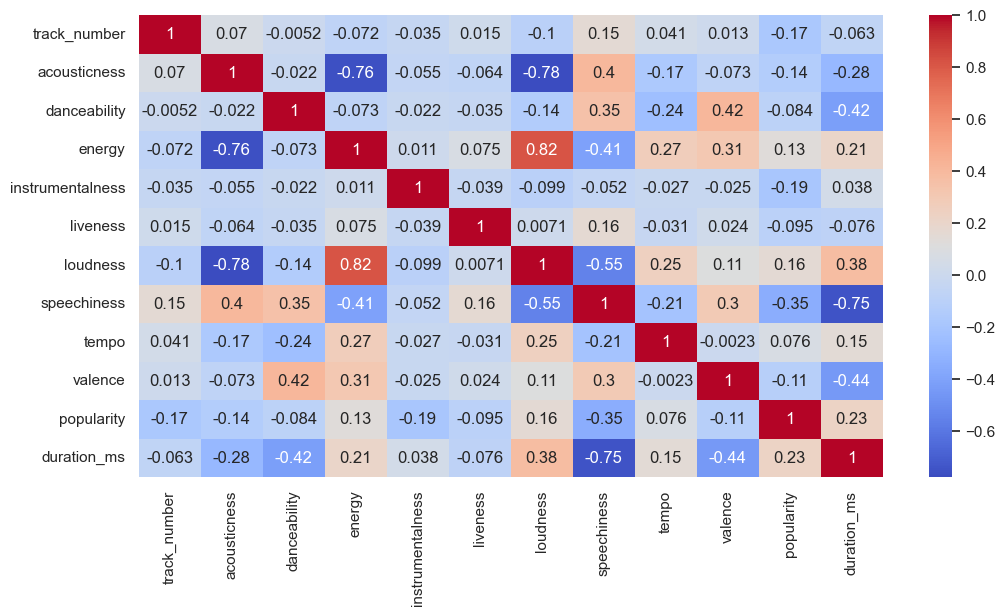

In [9]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
corr = raw2.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")

Text(0.5, 1.0, 'Cleaned Popularity')

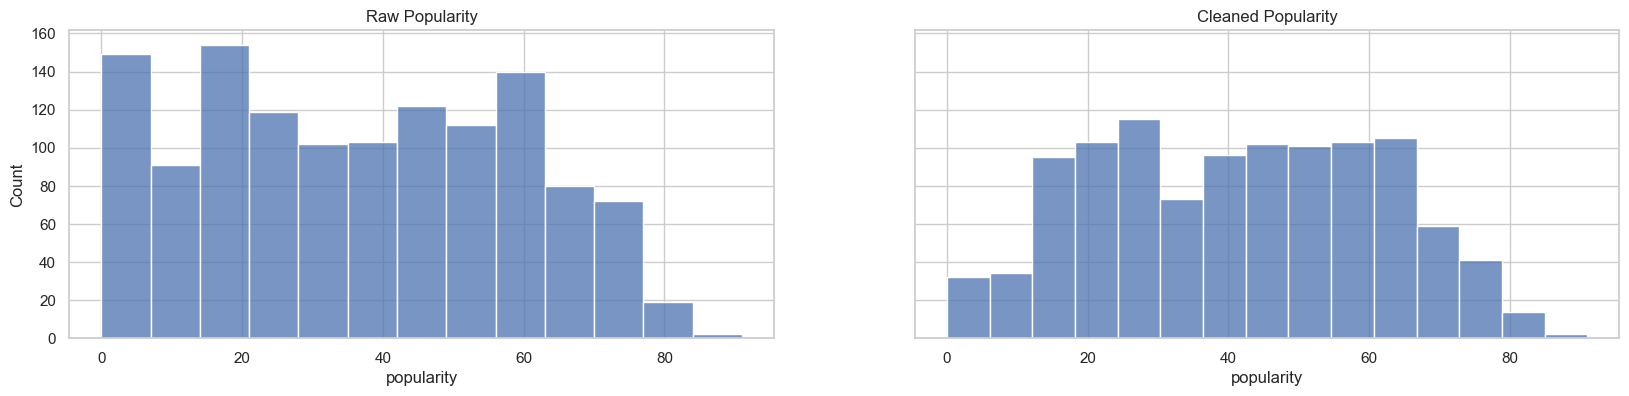

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4), sharey=True)

sns.histplot(raw["popularity"],bins='auto', ax=axes[0])
sns.histplot(raw2["popularity"],bins='auto', ax=axes[1])

axes[0].set_title('Raw Popularity')
axes[1].set_title('Cleaned Popularity')

In [11]:
raw = raw2
raw['album'].value_counts()

folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]    68
Fearless                                                                               63
Red (Taylor's Version)                                                                 60
reputation Stadium Tour Surprise Song Playlist                                         46
evermore                                                                               45
Red (Deluxe Edition)                                                                   44
Midnights (3am Edition)                                                                40
1989                                                                                   39
1989 (Deluxe)                                                                          38
evermore (deluxe version)                                                              34
folklore (deluxe version)                                                              34
1989 (Delu

Date/Time Manipulation

In [12]:
# Convert the release_date to datetime type
raw['release_date'] = pd.to_datetime(raw['release_date'])

/var/folders/s6/c2zvps5x2ds8_cjl3p1hyq440000gn/T/ipykernel_78422/2155717213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['release_date'] = pd.to_datetime(raw['release_date'])


In [13]:
raw2['release_date'] = pd.to_datetime(raw2['release_date'])

/var/folders/s6/c2zvps5x2ds8_cjl3p1hyq440000gn/T/ipykernel_78422/685110610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw2['release_date'] = pd.to_datetime(raw2['release_date'])


In [14]:
# Create features for each day/month/year each song was released.
month_of_release = raw['release_date'].dt.month
day_of_month = raw['release_date'].dt.day
year_of_release = raw['release_date'].dt.year

In [15]:
# Create features for each day/month/year each song was released.
month_of_release2 = raw2['release_date'].dt.month
day_of_month2 = raw2['release_date'].dt.day
year_of_release2 = raw2['release_date'].dt.year

Text(0.5, 1.0, 'Year of release')

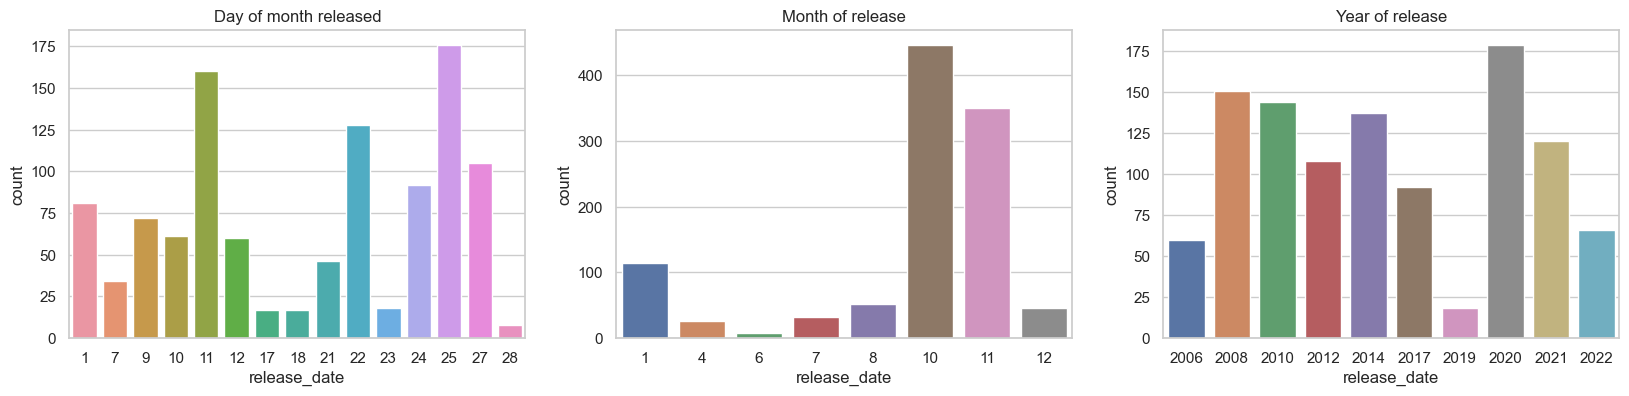

In [16]:
# Visualise by release 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4), sharey=False)

sns.countplot(x=day_of_month, ax=axes[0])
sns.countplot(x=month_of_release, ax=axes[1])
sns.countplot(x=year_of_release, ax=axes[2])

axes[0].set_title('Day of month released')
axes[1].set_title('Month of release')
axes[2].set_title('Year of release')

Text(0.5, 1.0, 'Year of release')

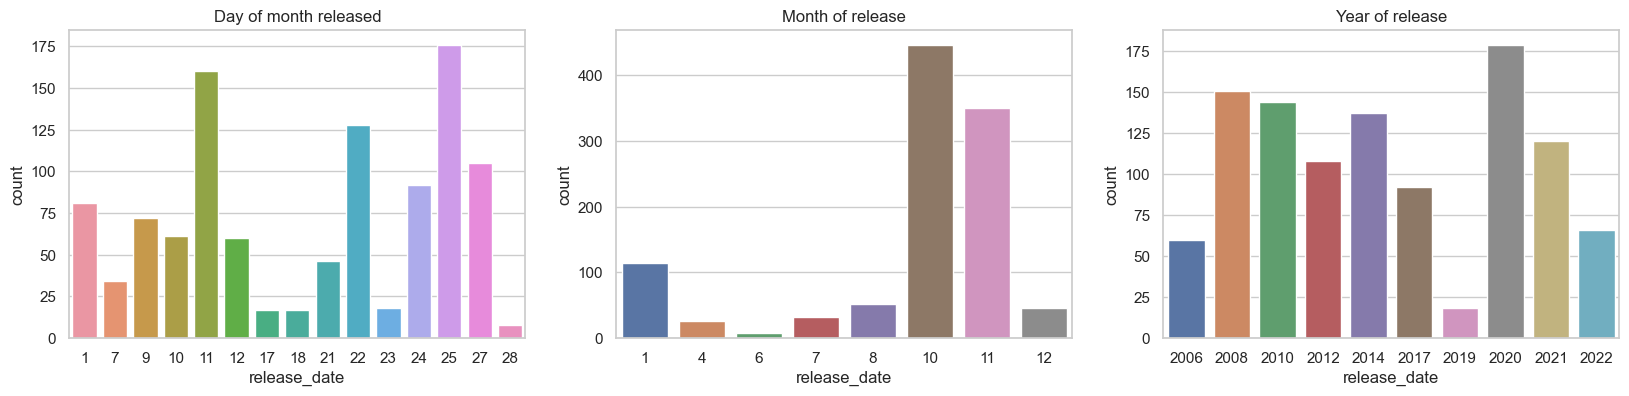

In [17]:
# Visualise by release 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4), sharey=False)

sns.countplot(x=day_of_month2, ax=axes[0])
sns.countplot(x=month_of_release2, ax=axes[1])
sns.countplot(x=year_of_release2, ax=axes[2])

axes[0].set_title('Day of month released')
axes[1].set_title('Month of release')
axes[2].set_title('Year of release')

In [18]:
# Drop some unnecessary columns that are not required when building the models
df = pd.DataFrame(raw.drop(columns=['name', 'id', 'uri']))

In [19]:
# Drop some unnecessary columns that are not required when building the models
df2 = pd.DataFrame(raw2.drop(columns=['name', 'id', 'uri']))

In [20]:
# one hot encode the album column
ohe_album = pd.get_dummies(df['album'])

In [21]:
# one hot encode the album column
ohe_album2 = pd.get_dummies(df2['album'])

In [22]:
# Create a Features table
features = pd.DataFrame({
    'track_number' : raw['track_number'],
    'acousticness' : raw['acousticness'],
    'danceability' : raw['danceability'],
    'energy' : raw['energy'],
    'instumentalness' : raw['instrumentalness'],
    'liveness' : raw['liveness'],
    'loudness' : raw['loudness'],
    'speechiness' : raw['speechiness'],
    'tempo' : raw['tempo'],
    'valence' : raw['valence'],
    'duration_ms' : raw['duration_ms'],
    'month_of_release' : month_of_release,
    'day_of_month' : day_of_month,
    'year_of_release': year_of_release
})

In [23]:
# Create a Features table
features2 = pd.DataFrame({
    'track_number' : raw2['track_number'],
    'acousticness' : raw2['acousticness'],
    'danceability' : raw2['danceability'],
    'energy' : raw2['energy'],
    'instumentalness' : raw2['instrumentalness'],
    'liveness' : raw2['liveness'],
    'loudness' : raw2['loudness'],
    'speechiness' : raw2['speechiness'],
    'tempo' : raw2['tempo'],
    'valence' : raw2['valence'],
    'duration_ms' : raw2['duration_ms'],
    'month_of_release' : month_of_release2,
    'day_of_month' : day_of_month2,
    'year_of_release': year_of_release2
})

In [24]:
# first step: include single feature values only
final_df = pd.concat([features, ohe_album], axis=1)

In [25]:
# first step: include single feature values only
final_df2 = pd.concat([features2, ohe_album2], axis=1)

In [26]:
final_df.columns = final_df.columns.str.replace(' ', '_')

In [27]:
final_df2.columns = final_df2.columns.str.replace(' ', '_')

In [28]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1075 entries, 0 to 1236
Data columns (total 49 columns):
 #   Column                                                                               Non-Null Count  Dtype  
---  ------                                                                               --------------  -----  
 0   track_number                                                                         1075 non-null   int64  
 1   acousticness                                                                         1075 non-null   float64
 2   danceability                                                                         1075 non-null   float64
 3   energy                                                                               1075 non-null   float64
 4   instumentalness                                                                      1075 non-null   float64
 5   liveness                                                                             1075 

In [29]:
final_df2

,track_number,acousticness,danceability,energy,instumentalness,liveness,loudness,speechiness,tempo,valence,...,Taylor_Swift,Taylor_Swift_(Big_Machine_Radio_Release_Special),evermore,evermore_(deluxe_version),folklore,folklore_(deluxe_version),folklore:_the_long_pond_studio_sessions_(from_the_Disney+_special)_[deluxe_edition],reputation,reputation_(Big_Machine_Radio_Release_Special),reputation_Stadium_Tour_Surprise_Song_Playlist
0,1,0.2040,0.735,0.444,0.001200,0.1700,-10.519,0.0684,97.038,0.0984,...,0,0,0,0,0,0,0,0,0,0
1,2,0.0593,0.658,0.378,0.000000,0.0976,-8.300,0.0379,108.034,0.0382,...,0,0,0,0,0,0,0,0,0,0
2,3,0.1330,0.638,0.634,0.000001,0.1520,-6.582,0.0457,96.953,0.5190,...,0,0,0,0,0,0,0,0,0,0
3,4,0.7350,0.659,0.323,0.003210,0.1160,-13.425,0.0436,110.007,0.1540,...,0,0,0,0,0,0,0,0,0,0
4,5,0.4160,0.694,0.380,0.000008,0.1260,-10.307,0.0614,120.044,0.3760,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,26,0.5970,0.612,0.384,0.000000,0.1640,-5.731,0.0240,96.020,0.2040,...,0,1,0,0,0,0,0,0,0,0
1233,27,0.8390,0.644,0.248,0.000000,0.1180,-12.282,0.9310,81.209,0.5600,...,0,1,0,0,0,0,0,0,0,0
1234,28,0.0036,0.489,0.760,0.000000,0.1110,-5.713,0.0362,156.088,0.2730,...,0,1,0,0,0,0,0,0,0,0
1235,29,0.8810,0.645,0.320,0.000000,0.1490,-11.998,0.9310,80.865,0.7050,...,0,1,0,0,0,0,0,0,0,0


(array([ 38.,  96., 114., 102., 138., 119., 155., 157., 107.,  49.]),
 array([0.118 , 0.2012, 0.2844, 0.3676, 0.4508, 0.534 , 0.6172, 0.7004,
        0.7836, 0.8668, 0.95  ]),
 <BarContainer object of 10 artists>)

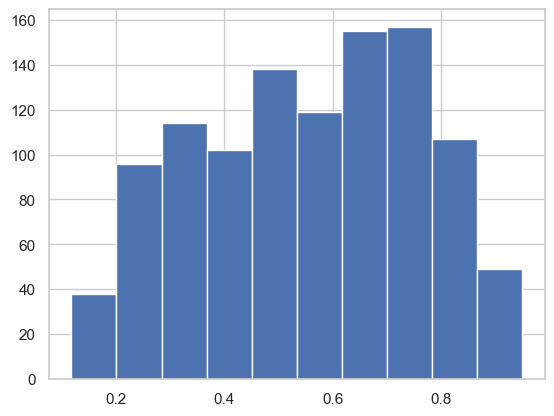

In [30]:
plt.hist(final_df2['energy'])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(final_df, raw['popularity'], test_size=0.1, random_state=42)

In [32]:
# Check the lengths of training/test data is as expected
print("Length of the X_train:", X_train.shape)
print("Length of the y_train:", y_train.shape)
print("Length of the X_test:", X_test.shape)
print("Length of the y_test:", y_test.shape)

Length of the X_train: (967, 49)
Length of the y_train: (967,)
Length of the X_test: (108, 49)
Length of the y_test: (108,)


Model Evaluation

In [33]:
# These will be used later for Model Comparision
names, mses, rmses, r2s = [], [], [], []

In [34]:
def display_metrics(y_test, y_preds, model_type):
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_preds)
    result = f'''
    {model_type} MSE  : {mse}
    {model_type} RMSE : {rmse} 
    {model_type} R^2  : {r2}
    '''
    
    names.append(model_type)
    mses.append(mse)
    rmses.append(rmse)
    r2s.append(r2)
    
    print(result)

Linear Regression Model

In [35]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

In [36]:
display_metrics(y_test, lr_preds, "Linear Regression")


    Linear Regression MSE  : 206.7547647909031
    Linear Regression RMSE : 14.37896953160772 
    Linear Regression R^2  : 0.46959221413816
    


Elastic Net Regression

In [37]:
elr = ElasticNet(alpha=0.1, random_state=42)
elr.fit(X_train, y_train)
elr_preds = elr.predict(X_test)

In [38]:
display_metrics(y_test, elr_preds, "Elastic Net Regression")


    Elastic Net Regression MSE  : 255.50094350275702
    Elastic Net Regression RMSE : 15.984396876415357 
    Elastic Net Regression R^2  : 0.3445389765698349
    


Support Vector Regressor

In [39]:
svr = SVR()
svr.fit(X_train, y_train)
svr_preds = svr.predict(X_test)

In [40]:
display_metrics(y_test, svr_preds, "Support Vector Regressor")


    Support Vector Regressor MSE  : 358.5185214947338
    Support Vector Regressor RMSE : 18.934585326717187 
    Support Vector Regressor R^2  : 0.08025812431071466
    


Decision Tree Regressor

In [41]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)
dtr_preds = dtr.predict(X_test)

In [42]:
display_metrics(y_test, dtr_preds, "Decision Tree Regressor")


    Decision Tree Regressor MSE  : 506.66898148148147
    Decision Tree Regressor RMSE : 22.509308773960196 
    Decision Tree Regressor R^2  : -0.2998064296329599
    


Random Forest Regressor

In [43]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
rfr_preds = rfr.predict(X_test)

In [44]:
display_metrics(y_test, rfr_preds, "Random Forest Regressor")


    Random Forest Regressor MSE  : 304.62956532602027
    Random Forest Regressor RMSE : 17.45364046054634 
    Random Forest Regressor R^2  : 0.21850462108557744
    


XGB Regressor

In [45]:
# Need to strip out []'s from the column names
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [46]:
xgb = xg.XGBRegressor()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

In [47]:
display_metrics(y_test, xgb_preds, "XGB Regressor")


    XGB Regressor MSE  : 350.19951715385065
    XGB Regressor RMSE : 18.713618494397352 
    XGB Regressor R^2  : 0.1015996623279174
    


Gradient Boosting Regressor

In [48]:
params = {'n_estimators': 660,
          'max_depth': 3,
          'min_samples_split': 3,
          'min_samples_leaf': 2,
          'learning_rate': 0.01
         } # instantiate and train the model
gbd_reg = ensemble.GradientBoostingRegressor(**params)
gbd_reg.fit(X_train, y_train)
gbd_preds = gbd_reg.predict(X_test)

In [49]:
display_metrics(y_test, gbd_preds, "Gradient Boosting Descent")


    Gradient Boosting Descent MSE  : 211.80947021971483
    Gradient Boosting Descent RMSE : 14.553675488333345 
    Gradient Boosting Descent R^2  : 0.45662489453422606
    


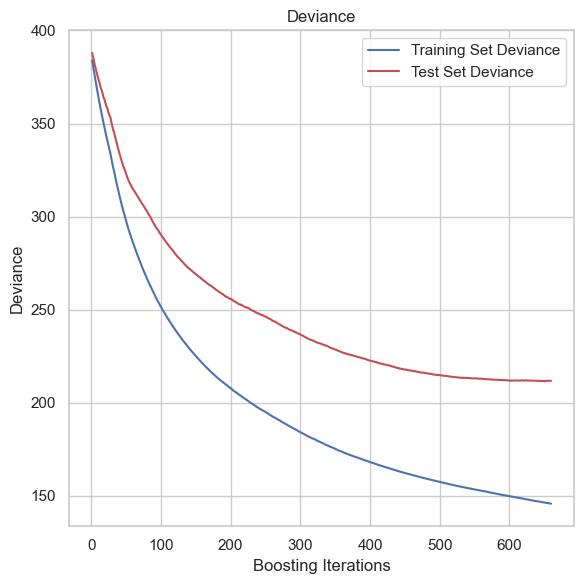

In [50]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbd_reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gbd_reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

Model Analysis

In [51]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1,cols=3, subplot_titles=('MSE', "RMSE", "R2"))

fig.add_bar(x=names, y=mses, row=1, col=1)
fig.add_bar(x=names, y=rmses, row=1, col=2)
fig.add_bar(x=names, y=r2s, row=1, col=3)

Investigating a Gradient Boosted Descent Model in more detail

In [52]:
# the mean of all popularity
mean_popularity = [round(y_train.mean(), 2)] * len(gbd_preds)
# baseline with some random popularity with the same mean and standard deviation of the training data values
random_popularity = [random.gauss(mu=y_train.mean(), sigma=y_train.std()) for i in range(len(gbd_preds))]

Text(0.5, 1.0, 'GBM vs True Values')

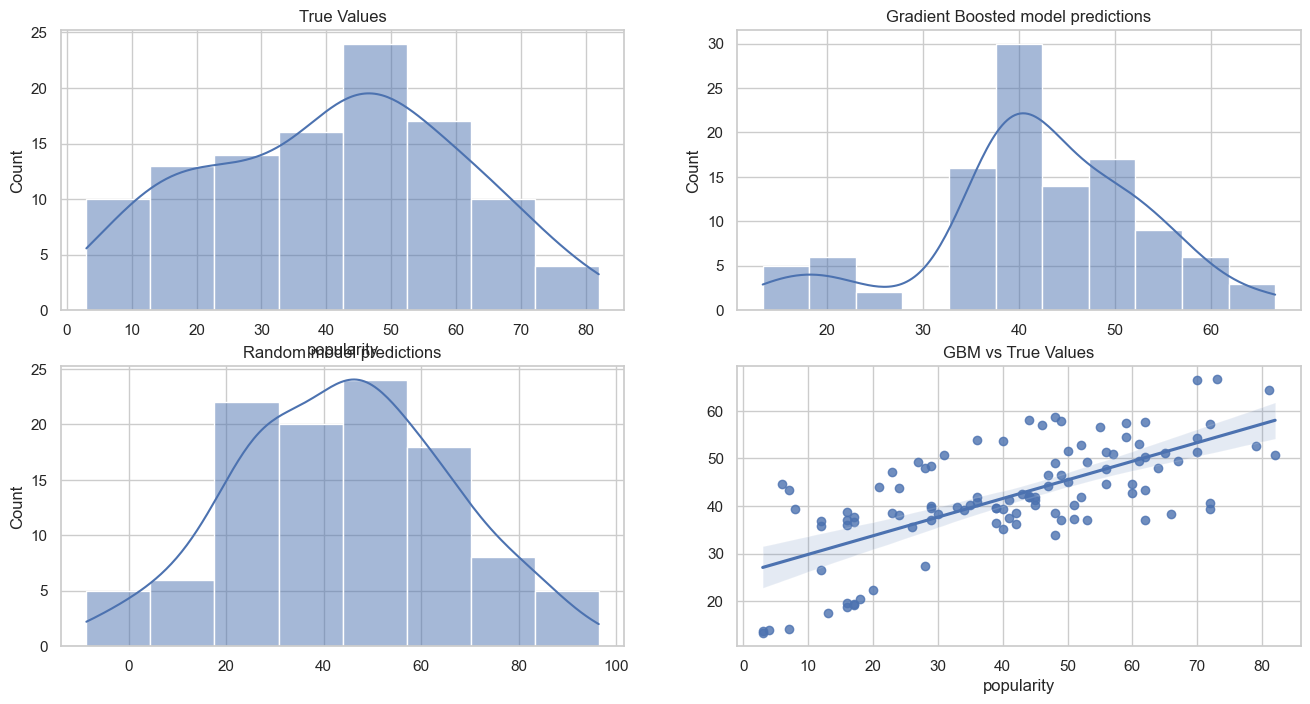

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), sharey=False, squeeze=False)

sns.histplot(y_test, ax=axes[0,0], kde=True)
sns.histplot(gbd_preds, ax=axes[0,1], kde=True)
sns.histplot(random_popularity, ax=axes[1,0], kde=True)
sns.regplot(x=y_test, y=gbd_preds, ax=axes[1,1])

axes[0,0].set_title('True Values')
axes[0,1].set_title('Gradient Boosted model predictions')
axes[1,0].set_title('Random model predictions')
axes[1,1].set_title('GBM vs True Values')

Feature Importance

In [54]:
# Get the feature importance and features as 2 lists
feature_imp = gbd_reg.feature_importances_
features = X_train.columns
# combine the 2 lists into a DataFrame
rel_imp_df = pd.DataFrame(index=features, data=feature_imp, columns=["importance"]).sort_values(by=['importance'], ascending=False)
rel_imp_df.head(25)

# Reset the index so we can get the feature name
rel_imp_df.reset_index(inplace=True)
# Rename the index column to feature
rel_imp_df = rel_imp_df.rename(columns={'index': 'feature'})
# return the refined feature list
ref_features = list(rel_imp_df.loc[rel_imp_df['importance'] >= 0.01, 'feature'])

In [55]:
# Due to matching the columns back up we need to clean the column names slightly before reselecting our features.
ref_features = [x.replace('_deluxe_edition_', '[deluxe edition]') for x in ref_features]
ref_features = [x.replace(' ', '_') for x in ref_features]

Retest With Refined Data

In [56]:
X_train, X_test, y_train, y_test = train_test_split(final_df[ref_features], raw['popularity'], test_size=0.1, random_state=42)
# Check the lengths of training/test data is as expected
print("Length of the X_train:", X_train.shape)
print("Length of the y_train:", y_train.shape)
print("Length of the X_test:", X_test.shape)
print("Length of the y_test:", y_test.shape)

Length of the X_train: (967, 18)
Length of the y_train: (967,)
Length of the X_test: (108, 18)
Length of the y_test: (108,)


In [57]:
def display_boosting_chart(model):
    test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
    for i, y_pred in enumerate(model.staged_predict(X_test)):
        test_score[i] = mean_squared_error(y_test, y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
        np.arange(params["n_estimators"]) + 1,
        model.train_score_,
        "b-",
        label="Training Set Deviance",
    )
    plt.plot(
        np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()


    Gradient Boosting Descent (Refined Features) MSE  : 206.4333796685652
    Gradient Boosting Descent (Refined Features) RMSE : 14.367789658418765 
    Gradient Boosting Descent (Refined Features) R^2  : 0.4704166941510902
    


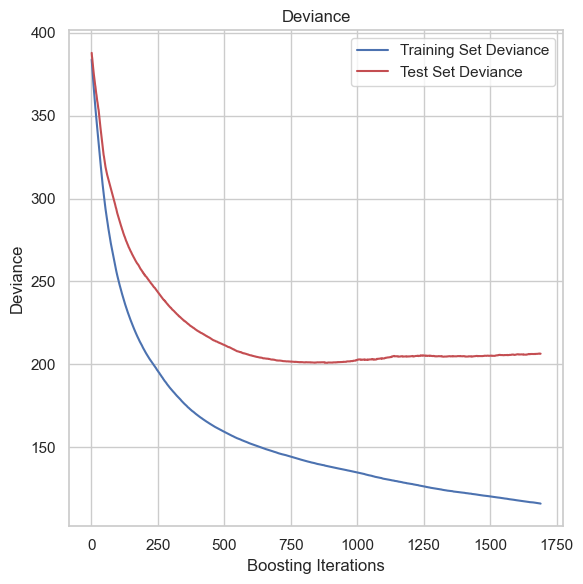

In [58]:
params = {'n_estimators': 1690,
          'max_depth': 3,
          'min_samples_split': 3,
          'min_samples_leaf': 2,
          'learning_rate': 0.01
         } # instantiate and train the model
gbd_reg_ref = ensemble.GradientBoostingRegressor(**params)
gbd_reg_ref.fit(X_train, y_train)
gbd_ref_preds = gbd_reg_ref.predict(X_test)

display_metrics(y_test, gbd_ref_preds, "Gradient Boosting Descent (Refined Features)")
display_boosting_chart(gbd_reg_ref)

Text(0.5, 1.0, 'Gradient Boosted (Refined) model predictions')

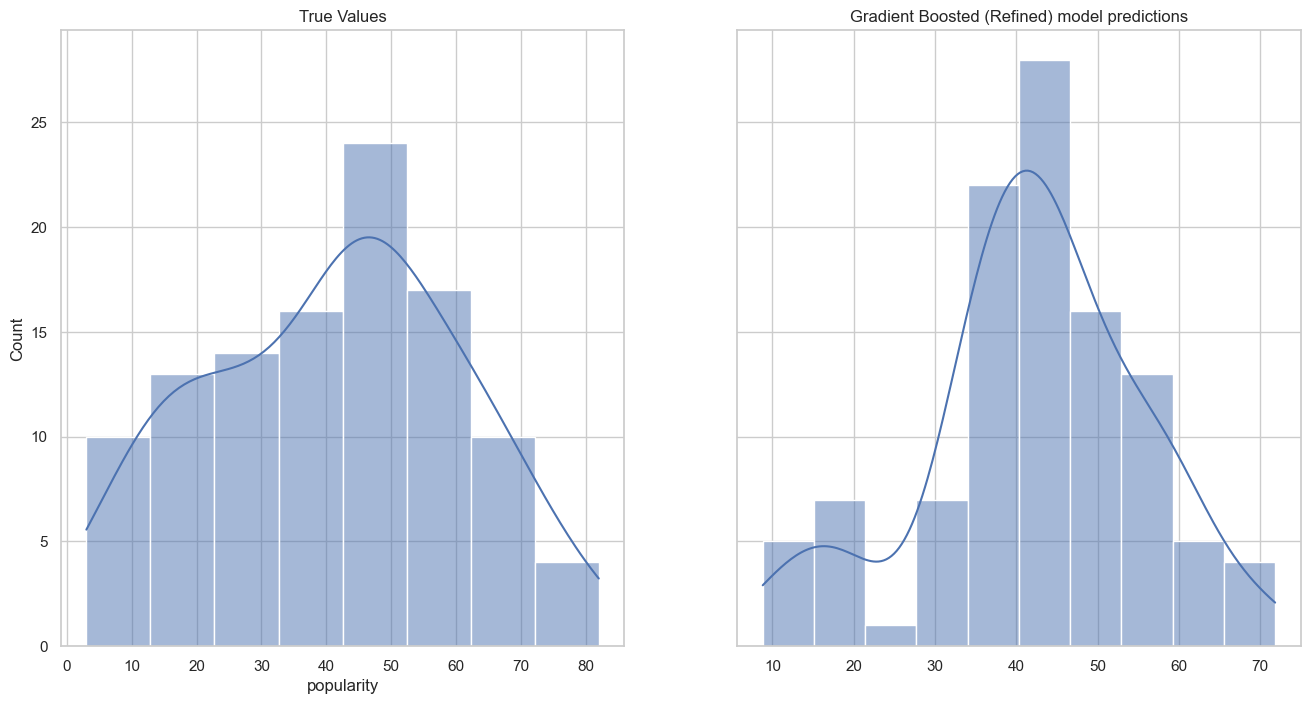

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharey=True)

sns.histplot(y_test, ax=axes[0], kde=True)
sns.histplot(gbd_ref_preds, ax=axes[1], kde=True)

axes[0].set_title('True Values')
axes[1].set_title('Gradient Boosted (Refined) model predictions')